In [1]:
import tensorflow as tf
import numpy as np

import h5py

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

%matplotlib inline

<h3>Preprocessing</h3>

In [2]:
input_file='./data.h5'
input_folder='data'

In [3]:
with h5py.File(input_file, 'r') as h5f:
    data=h5f['images'][:]
    
data=np.reshape(data, (1000,128,128))
shape=data.shape
shape

(1000, 128, 128)

In [4]:
# imshow(data[89], cmap=plt.get_cmap('gray'))

In [5]:
a=8 # 8*8=64 pixels in one batch (batch resolution)
q=2 # scaling coef

class Image_batcher:
    data=None
    shape=None
    cur=0
    
    def __init__(self, data, shape=(8,8)):
        self.shape=shape
        images=np.array(data)
        batches=[]
        for img in images:
            batches+=self.image_2_batch(img, shape)
        np.random.shuffle(batches)
        self.data=np.array(batches)
#         print(self.data.shape)
        
    def next_batch(self, n, q=2):
        res=self.data[self.cur:self.cur+n]
        self.cur+=n
        return {
            'origin': np.reshape(res, (n, self.shape[0]**2))
            , 'down': np.reshape(res[:,::q,::q], (n, int(self.shape[0]/q)**2))
        }
    
    def image_2_batch(self, image, shape=(8,8)):
        orig_shape=image.shape
        batches=[]
        for x in range(int(orig_shape[0]/shape[0])):
            for y in range(int(orig_shape[1]/shape[1])):
                batches.append(image[a*x:a*x+a, a*y:a*y+a])
        return batches
    
    def image_2_down_batch(self, image, shape=(8,8), q=2):
        img=self.image_2_batch(image, shape)
        down=[b[::q,::q] for b in img]
        return np.array(down)
    
    def batch_2_image(self, batch, shape=(128,128)):
        q=int(shape[0]/batch.shape[1])
        res=[]
        for k in range(q):
            for i in range(batch.shape[1]):
    #             print(res)
                res.append(batch[(q*k):(q*(k+1)),i].flat[:])
        return res  

<h3>Model</h3>

In [6]:
x = tf.placeholder(tf.float32, shape=[None, (a/q)**2])
y_ = tf.placeholder(tf.float32, shape=[None, a**2])

W = tf.Variable(tf.zeros([(a/q)**2, a**2]))
b = tf.Variable(tf.zeros([a**2]))

y = tf.matmul(x,W) + b

mse = tf.losses.mean_squared_error(labels=y_, predictions=y)

train_step = tf.train.GradientDescentOptimizer(0.05).minimize(mse)

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

image_batcher=Image_batcher(data, shape=(a,a))

for _ in range(1000):
    batch=image_batcher.next_batch(100, q)
    
    train_step.run(feed_dict={
        x: batch['down']
        , y_: batch['origin']
    })

In [8]:
weight=W.eval()

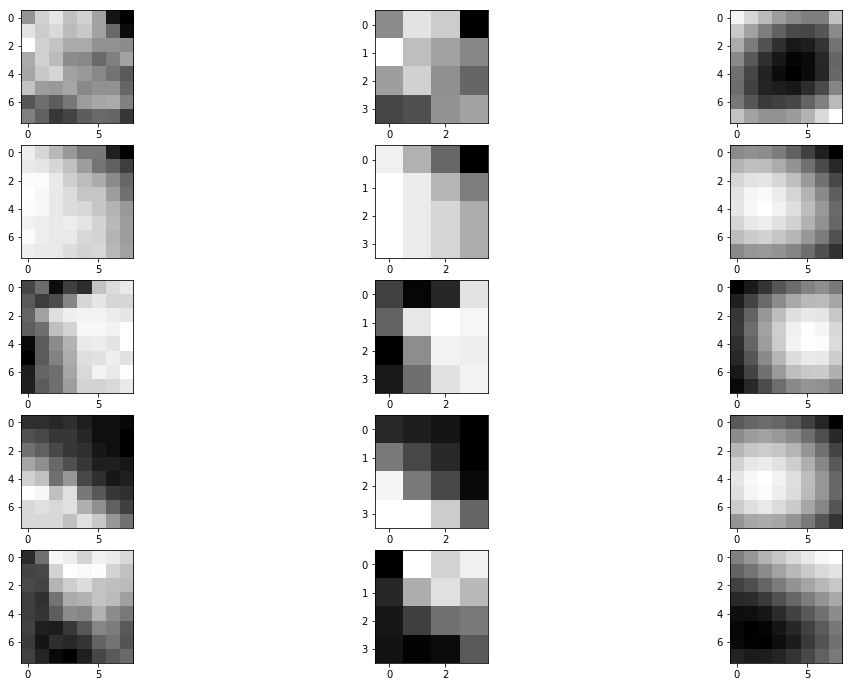

In [16]:
fig=plt.figure(figsize=(18, 12))

for i in range(5):
    temp_batch=image_batcher.next_batch(1)
    fig.add_subplot(5,3,3*i+1)
    imshow(np.reshape(temp_batch['origin'], (8,8)), cmap=plt.get_cmap('gray'))
    fig.add_subplot(5,3,3*i+2)
    imshow(np.reshape(temp_batch['down'], (4,4)), cmap=plt.get_cmap('gray'))
    fig.add_subplot(5,3,3*i+3)
    imshow(np.reshape(np.matmul(temp_batch['down'], weight), (8,8)), cmap=plt.get_cmap('gray'));

<h3>Image batcher test</h3>

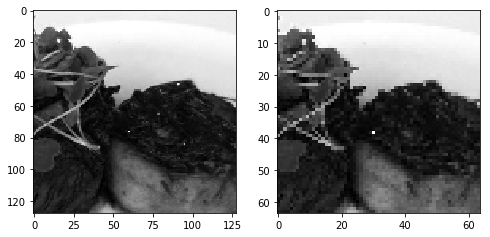

In [10]:
image_batcher=Image_batcher(data, shape=(a,a))
test_image=data[34]
test_image_down_batch=image_batcher.image_2_down_batch(test_image)
test_down_image=image_batcher.batch_2_image(test_image_down_batch, shape=(64,64))

fig=plt.figure(figsize=(8, 4))
fig.add_subplot(121)
imshow(test_image, cmap=plt.get_cmap('gray'))
fig.add_subplot(122)
imshow(np.array(test_down_image), cmap=plt.get_cmap('gray'));

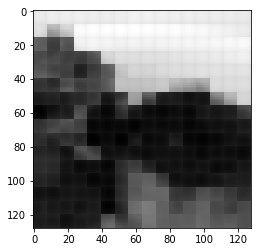

In [11]:
z=np.matmul(np.reshape(test_image_down_batch, (256,16)), weight)
imshow(image_batcher.batch_2_image(np.reshape(z, (256, 8,8)), shape=(128,128)), cmap=plt.get_cmap('gray'));